In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm
import statsmodels.api as sm
import pickle
from joblib import load
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# Load analysis datasets

In [2]:
alldiag_pivot = pd.read_parquet('pivot_table_final1.parquet')

# Dimentional Reduction

## (If necessary) Sampling from the dataset

In [3]:
alldiag_pivot_sp = alldiag_pivot

In [4]:
y = alldiag_pivot_sp["isAD"].replace({1:"Alzheimer", 0:"Control"})

In [5]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [6]:
z = alldiag_pivot_sp[demographic_cols]
X = alldiag_pivot_sp.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [7]:
X

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,Zenker diverticula,Zenker's hypopharyngeal diverticulum,Zonular dehiscence,Zoster iridocyclitis,Zoster vaccine,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC)
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF1B8ED4683F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF226D09433C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA(n=1750)

In [8]:
pca = joblib.load('pca1750_model.joblib')
data_pca = np.load('data_pca1750_final1.npy')

## Kmeans Clustering

In [9]:
# K-means Clustering(n =2)
kmeans2 = KMeans(n_clusters=2, random_state=42) 
kmeans2.fit(data_pca)
data_pca_kmeans2 = kmeans2.fit_transform(data_pca)

In [10]:
kmeans2_labels = kmeans2.labels_

## UMAP visualization

In [11]:
'''
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True, verbose = 1)
X_embedded = mapper.fit_transform(data_pca)
'''

"\n%%time\nmapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True, verbose = 1)\nX_embedded = mapper.fit_transform(data_pca)\n"

In [12]:
with open('umap_results.pkl', 'rb') as file:
    X_embedded = pickle.load(file)

In [13]:
loaded_umap_model = load('umap_model.joblib')

Sat Mar  9 23:26:15 2024 Building and compiling search function


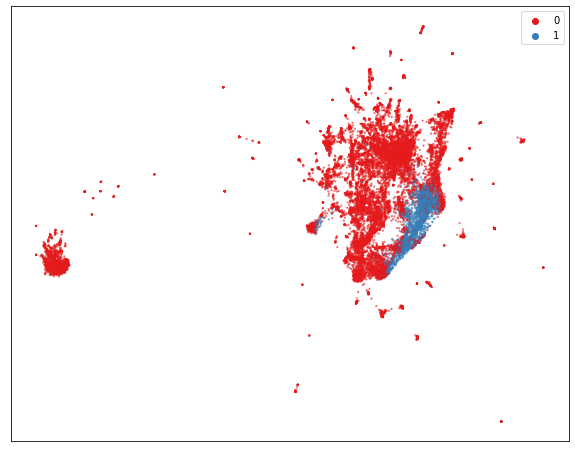

In [14]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = kmeans2.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## UMAP Visualization colored by AD

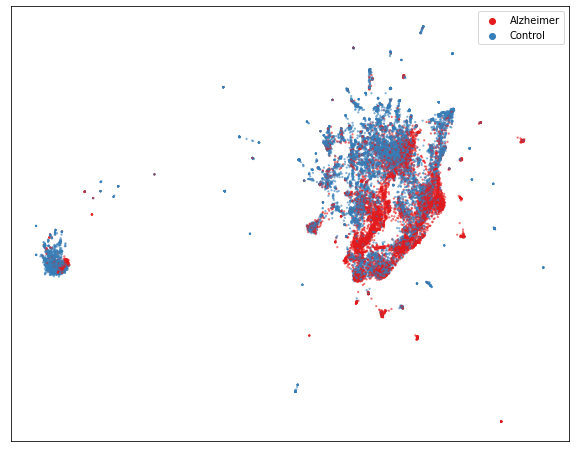

In [15]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    np.random.seed(0)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = y[reordered_indices].values, 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [16]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(kmeans2_labels, y)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 0.3868081144103205
P-value: 9.638032395661415e-121


In [17]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,7044,11423
1,1760,1104


In [18]:
X['cluster1'] = kmeans2_labels

In [19]:
y_float = y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X['cluster1'] , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model1 = sm.Logit(y_train, X_with_intercept)
log_reg1 = log_model1.fit()

print(log_reg1.summary())

Optimization terminated successfully.
         Current function value: 0.665127
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                17064
Model:                          Logit   Df Residuals:                    17062
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                 0.01867
Time:                        23:26:19   Log-Likelihood:                -11350.
converged:                       True   LL-Null:                       -11566.
Covariance Type:            nonrobust   LLR p-value:                 6.703e-96
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4834      0.017    -28.537      0.000      -0.517      -0.450
cluster1       0.9429      0.

In [20]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg1.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6189360206233888


# Re-Kmeans Clustering after narrow down the data

In [21]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg1.params)
selected_data = data_pca[kmeans2_labels == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_kmeans = KMeans(n_clusters=2, random_state=42)
recluster_kmeans.fit(selected_data)
recluster_labels = recluster_kmeans.labels_

In [22]:
sub_labels = recluster_labels

In [23]:
final_labels = kmeans2_labels.copy()
if selected_cluster == 1 :
    final_labels[kmeans2_labels == selected_cluster] = sub_labels + 1  # New cluster labels are 1 and 2 because cluster 0 alreadt existed.
elif selected_cluster ==0 :
    final_labels[kmeans2_labels == selected_cluster] = sub_labels + 2  # New cluster labels are 2 and 3 because cluster 1 alreadt existed.

In [24]:
np.unique(final_labels)

array([1, 2, 3], dtype=int32)

## UMAP Visualization

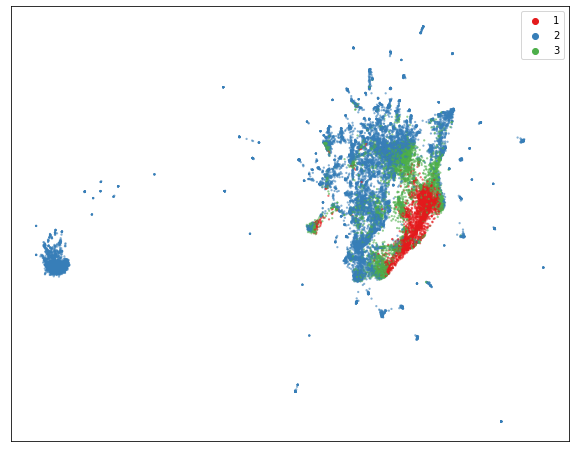

In [25]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [26]:
selected_y = y[kmeans2_labels == selected_cluster]


In [27]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels, selected_y)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 0.5877238866089434
P-value: 1.8871018843188431e-53


In [28]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,4835,9005
1,2209,2418


In [29]:
sub_labels = recluster_labels

In [30]:
sub_label_df = pd.DataFrame(sub_labels, columns = ['cluster2'])

In [31]:
y_float = selected_y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model2 = sm.Logit(y_train, X_with_intercept)
log_reg2 = log_model2.fit()

print(log_reg2.summary())

Optimization terminated successfully.
         Current function value: 0.658905
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                14773
Model:                          Logit   Df Residuals:                    14771
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                0.009879
Time:                        23:26:28   Log-Likelihood:                -9734.0
converged:                       True   LL-Null:                       -9831.1
Covariance Type:            nonrobust   LLR p-value:                 3.764e-44
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6170      0.020    -30.979      0.000      -0.656      -0.578
cluster2       0.5375      0.

In [32]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg2.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6245262587980509


# Re-Kmeans Clustering after narrow down the data

In [33]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg2.params)
selected_data1 = selected_data[sub_labels == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_kmeans1 = KMeans(n_clusters=2, random_state=42)
recluster_kmeans1.fit(selected_data1)
recluster_labels1 = recluster_kmeans1.labels_

In [34]:
final_labels_1 = final_labels.copy()
if selected_cluster == 1 :
    final_labels_1[final_labels == 3] = recluster_labels1 + 3  # New cluster labels are 3 and 4
elif selected_cluster ==0 :
    final_labels_1[final_labels == 2] = recluster_labels1 + 4  # New cluster labels are 4 and 5

In [35]:
np.unique(final_labels_1)

array([1, 3, 4, 5], dtype=int32)

## UMAP Visualization

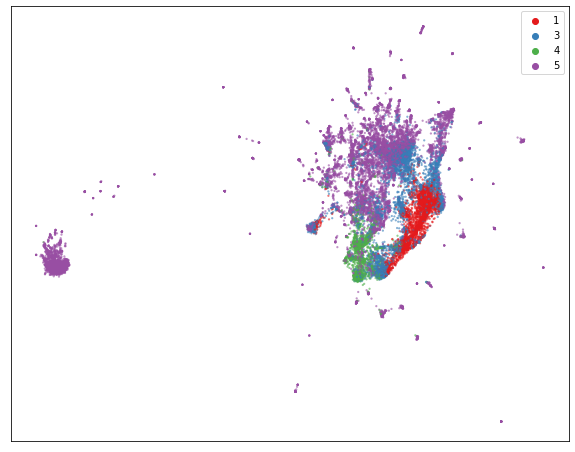

In [36]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_1[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [37]:
label_df = pd.DataFrame(recluster_labels1, columns=['labels'])

In [38]:
selected_y_1 = selected_y[recluster_labels == selected_cluster]

In [39]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels1, selected_y_1)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 5.598205218474537
P-value: 6.644226774590114e-256


In [40]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,1377,598
1,3458,8407


In [41]:
sub_label_df = pd.DataFrame(recluster_labels1, columns = ['cluster4'])

In [42]:
y_float = selected_y_1.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model4 = sm.Logit(y_train, X_with_intercept)
log_reg4 = log_model4.fit()

print(log_reg4.summary())

Optimization terminated successfully.
         Current function value: 0.603028
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                11072
Model:                          Logit   Df Residuals:                    11070
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                 0.06656
Time:                        23:26:33   Log-Likelihood:                -6676.7
converged:                       True   LL-Null:                       -7152.8
Covariance Type:            nonrobust   LLR p-value:                4.516e-209
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8559      0.055     15.445      0.000       0.747       0.964
cluster4      -1.7521      0.

In [43]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg4.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.6986994219653179


## Compare the clusters by Logistic Regression

In [44]:
X['Cluster4'] = final_labels_1

In [45]:
# OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop= "first")

# Encoding the Cluster id
X_encoded = encoder.fit_transform(X[['Cluster4']])

# Data Frame of the encoded clusters
X_encoded_df = pd.DataFrame(X_encoded, columns=[f'Cluster_{i+1}' for i in range(X_encoded.shape[1])])

In [46]:
X_encoded_df

,Cluster_1,Cluster_2,Cluster_3
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
21326,1.0,0.0,0.0
21327,0.0,0.0,1.0
21328,0.0,0.0,1.0
21329,0.0,0.0,1.0


In [47]:
y_float = y.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_with_intercept = sm.add_constant(X_train.astype(float))


log_model4_1 = sm.Logit(y_train, X_with_intercept)
log_reg4_1 = log_model4_1.fit()

print(log_reg4_1.summary())

Optimization terminated successfully.
         Current function value: 0.632425
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                17064
Model:                          Logit   Df Residuals:                    17060
Method:                           MLE   Df Model:                            3
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:                 0.06691
Time:                        23:26:42   Log-Likelihood:                -10792.
converged:                       True   LL-Null:                       -11566.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4595      0.043     10.721      0.000       0.376       0.544
Cluster_1     -0.5416      0.

# Re-Kmeans Clustering after narrow down the data

In [48]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg4.params)
selected_data2 = selected_data1[recluster_labels1 == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_kmeans2 = KMeans(n_clusters=2, random_state=42)
recluster_kmeans2.fit(selected_data2)
recluster_labels2 = recluster_kmeans2.labels_

In [49]:
final_labels_2 = final_labels_1.copy()
if selected_cluster == 1 :
    final_labels_2[final_labels_1 == 5] = recluster_labels2 + 5  # New cluster labels are 5 and 6
elif selected_cluster ==0 :
    final_labels_2[final_labels_1 == 4] = recluster_labels2 + 6  # New cluster labels are 6 and 7

In [50]:
np.unique(final_labels_2)

array([1, 3, 4, 5, 6], dtype=int32)

## UMAP Visualization

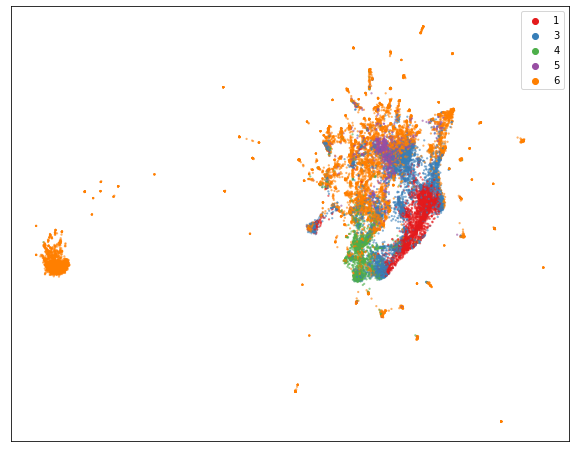

In [51]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_2[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Odds Ratio

In [52]:
label_df = pd.DataFrame(recluster_labels2, columns=['labels'])

In [53]:
selected_y_2 = selected_y_1[recluster_labels1 == selected_cluster]

In [54]:
# Cross table of cluster and AD
cross_tab = pd.crosstab(recluster_labels2, selected_y_2)

# Calculate Odds ratio
odds_ratio, p_value = fisher_exact(cross_tab)

print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)

Odds Ratio: 0.8932529072926856
P-value: 0.07791491273140061


In [55]:
cross_tab

isAD,Alzheimer,Control
row_0,,
0,391,1050
1,3067,7357


In [56]:
sub_label_df = pd.DataFrame(recluster_labels2, columns = ['cluster6'])

In [57]:
y_float = selected_y_2.replace({"Alzheimer":1, "Control":0})

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(sub_label_df , y_float, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_with_intercept = sm.add_constant(X_train.astype(float))

# Train the logistic model on the train data
log_model6 = sm.Logit(y_train, X_with_intercept)
log_reg6 = log_model6.fit()

print(log_reg6.summary())

Optimization terminated successfully.
         Current function value: 0.601641
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   isAD   No. Observations:                 9492
Model:                          Logit   Df Residuals:                     9490
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Mar 2024   Pseudo R-squ.:               0.0001143
Time:                        23:26:48   Log-Likelihood:                -5710.8
converged:                       True   LL-Null:                       -5711.4
Covariance Type:            nonrobust   LLR p-value:                    0.2533
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9687      0.066    -14.568      0.000      -1.099      -0.838
cluster6       0.0804      0.

In [58]:
# Calculate the accuracy on the test data
X_test_sm = sm.add_constant(X_test)

y_pred_prob = log_reg6.predict(X_test_sm)

# set the threshold is 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

Accuracy: 0.7008006742520017


# Re-Kmeans Clustering after narrow down the data

In [59]:
# Choose a cluster that have the maximum coefficient
selected_cluster = np.argmin(log_reg6.params)
selected_data3 = selected_data2[recluster_labels2 == selected_cluster]

# Re-Kmeans clustering to the selected cluster
recluster_kmeans3 = KMeans(n_clusters=2, random_state=42)
recluster_kmeans3.fit(selected_data3)
recluster_labels3 = recluster_kmeans3.labels_

In [60]:
final_labels_3 = final_labels_2.copy()
if selected_cluster == 1 :
    final_labels_3[final_labels_2 == 6] = recluster_labels3 + 6  # New cluster labels are 6 and 6
elif selected_cluster ==0 :
    final_labels_3[final_labels_2 == 5] = recluster_labels3 + 7  # New cluster labels are 7 and 8

In [61]:
np.unique(final_labels_3)

array([1, 3, 4, 6, 7, 8], dtype=int32)

## UMAP Visualization

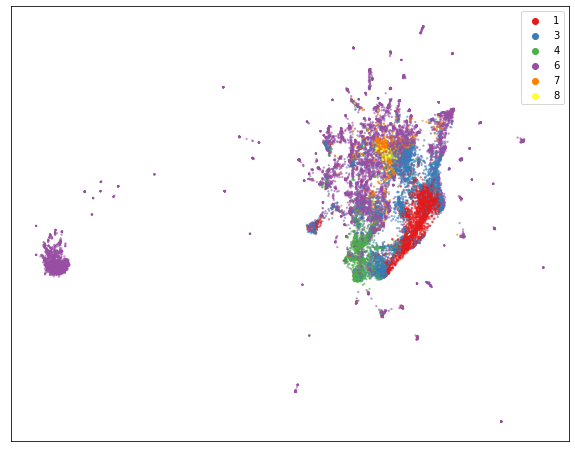

In [62]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels_3[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Elbow Plot

In [63]:
X.columns

Index(['"walking corpse" syndrome',
       ''light-for-dates' infant with signs of fetal malnutrition',
       '(HFpEF) heart failure with preserved ejection fraction (HCC)',
       '(Idiopathic) normal pressure hydrocephalus (HCC)', '*Unknown',
       '1st MTP arthritis', '1st degree AV block',
       '2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture',
       '2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing',
       '2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture',
       ...
       'Zonular dehiscence', 'Zoster iridocyclitis', 'Zoster vaccine',
       'Zygomatic fracture, left side, initial encounter for closed fracture (HCC)',
       'Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)',
       'Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing

In [64]:
X = X.drop(['cluster1', 'Cluster4'], axis=1)

In [65]:

# Get the number of clusters
n_clusters2 = len(np.unique(kmeans2_labels))
n_clusters3 = len(np.unique(final_labels))
n_clusters4 = len(np.unique(final_labels_1))
n_clusters5 = len(np.unique(final_labels_2))
n_clusters6 = len(np.unique(final_labels_3))

# List to store cluster center point
cluster_centers2 = []
cluster_centers3 = []
cluster_centers4 = []
cluster_centers5 = []
cluster_centers6 = []



# Process for each cluster
for i in range(n_clusters2):
    # Get data points for cluster i
    cluster_data = data_pca[kmeans2_labels == i]
    
    # Calculate the center point (average) of the cluster
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers2.append(cluster_center)
    
for i in range(n_clusters3):
    cluster_data = data_pca[final_labels == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers3.append(cluster_center)
    
    
for i in range(n_clusters4):
    cluster_data = data_pca[final_labels_1 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers4.append(cluster_center)
    
for i in range(n_clusters5):
    cluster_data = data_pca[final_labels_2 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers5.append(cluster_center)
    
for i in range(n_clusters6):
    cluster_data = data_pca[final_labels_3 == i]
    
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers6.append(cluster_center)

# Calculate WSS
wss2 = 0
wss3 = 0
wss4 = 0
wss5 = 0
wss6 = 0

for i in range(n_clusters2):
    cluster_data = data_pca[kmeans2_labels == i]
    cluster_center = cluster_centers2[i]
    
    wss2 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss2)

for i in range(n_clusters3):
    cluster_data = data_pca[final_labels == i]
    cluster_center = cluster_centers3[i]
    
    wss3 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss3)

for i in range(n_clusters4):
    cluster_data = data_pca[final_labels_1 == i]
    cluster_center = cluster_centers4[i]
    
    wss4 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss4)

for i in range(n_clusters5):
    cluster_data = data_pca[final_labels_2 == i]
    cluster_center = cluster_centers5[i]
    
    wss5 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss5)

for i in range(n_clusters6):
    cluster_data = data_pca[final_labels_3 == i]
    cluster_center = cluster_centers6[i]
    
    wss6 += np.sum((cluster_data - cluster_center) ** 2)

print('WSS:', wss6)


/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


WSS: 682462.9882539397
WSS: 504059.20329244004
WSS: 576500.0896871075
WSS: 605230.4842731183
WSS: 605230.4842731183


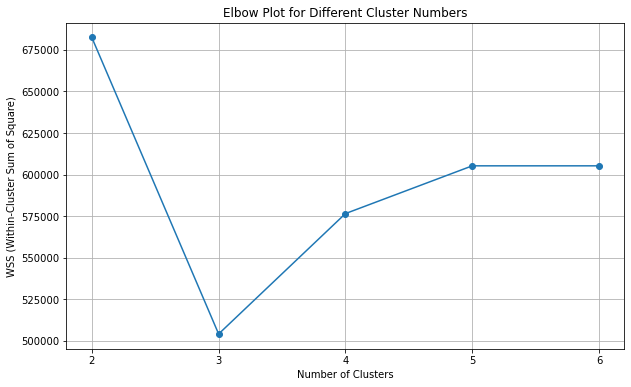

In [66]:
cluster_numbers = [n_clusters2, n_clusters3, n_clusters4, n_clusters5, n_clusters6]
wss_values = [wss2, wss3, wss4, wss5,wss6]

plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, wss_values, marker='o', linestyle='-')
plt.title('Elbow Plot for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Within-Cluster Sum of Square)')
plt.xticks(cluster_numbers)
plt.grid(True)
plt.show()


In [67]:
silhouette_avg2 = silhouette_score(data_pca, kmeans2_labels)
silhouette_avg3 = silhouette_score(data_pca, final_labels)
silhouette_avg4 = silhouette_score(data_pca, final_labels_1)
silhouette_avg5 = silhouette_score(data_pca, final_labels_2)
silhouette_avg6 = silhouette_score(data_pca, final_labels_3)

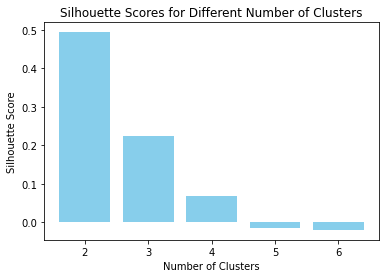

In [68]:
silhouette_avgs = [silhouette_avg2, silhouette_avg3, silhouette_avg4, silhouette_avg5, silhouette_avg6]


n_clusters = [2, 3, 4, 5, 6]

plt.bar(n_clusters, silhouette_avgs, color='skyblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xticks(n_clusters)
plt.show()

# The best number of clusters is 3

# Save the pivot table with cluster numbers

In [69]:
np.unique(final_labels)

array([1, 2, 3], dtype=int32)

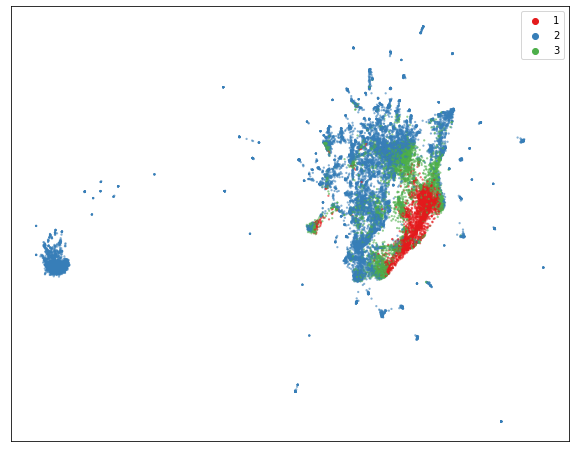

In [70]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = final_labels[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

In [71]:
X['Cluster5'] = final_labels

In [72]:
# OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop= "first")

# Encoding the Cluster id
X_encoded = encoder.fit_transform(X[['Cluster5']])

# Data Frame of the encoded clusters
X_encoded_df = pd.DataFrame(X_encoded, columns=[f'Cluster_{i+2}' for i in range(X_encoded.shape[1])])

In [73]:
X_encoded_df

,Cluster_2,Cluster_3
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,0.0
4,0.0,1.0
...,...,...
21326,0.0,1.0
21327,1.0,0.0
21328,1.0,0.0
21329,1.0,0.0


In [74]:
X_encoded_df.index = z.index

In [75]:
df_bg = z.join(X_encoded_df)

In [76]:
labels = pd.DataFrame(final_labels, columns=['Cluster'])

In [77]:
labels.index = df_bg.index

In [78]:
df_bg = df_bg.join(labels)

In [79]:
AD = pd.DataFrame(y, columns = ['isAD'])

In [80]:
df_bg = df_bg.join(AD)

In [81]:
df_bg.to_csv('df_kmeans_cluster3_final1.csv', index=False)